In [10]:
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime.estimator import Estimator

from QuditsOnQubits import QuditsOnQubits
import numpy as np
import numpy as np
import networkx as nx

Definicja Z i X qutrytowych zakodowanych na qubitach

In [13]:
omega = np.exp(2*np.pi*1.j/3)
Z = [[1, 0, 0, 0], [0, omega, 0, 0], [0, 0, omega*omega, 0], [0, 0, 0, 1]]
X = [[0,0,1,0], [1,0,0,0], [0,1,0,0],[0,0,0,1]]

Tworze graf ame43

5

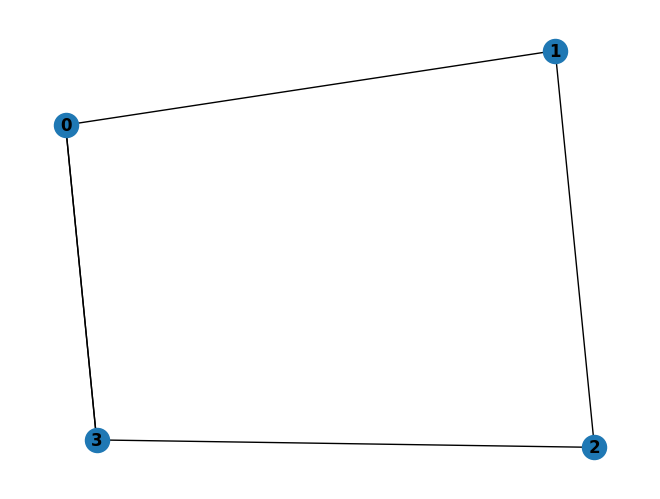

In [14]:
SQ = nx.MultiGraph()

#dodawanie wezlow
SQ.add_nodes_from([0, 3])

#dodawanie kolejnych krawedzi
SQ.add_edge(0, 1)
SQ.add_edge(1, 2)
SQ.add_edge(2, 3)
SQ.add_edge(3, 0)
SQ.add_edge(0, 3)

#rysowania grafu
nx.draw(SQ, with_labels=True, font_weight='bold')

#wypisywanie liczby krawedzi
SQ.number_of_edges()

Tworze stan grafowy uzywajac stworzonej biblioteki QuditsOnQubits gdzie w argumencie mam graf

In [15]:
ame43 = QuditsOnQubits(SQ)

Tworze obwod z grafu

In [19]:
ame43circ = ame43.circuit

Tworze stabilizatory według pracy Santosa. Wzor nr. 42 na stronie 11. 

In [20]:
G1 = np.kron(X, np.kron(Z, np.kron(np.identity(4), Z)))
G1G2 = np.kron(np.dot(X, Z), np.kron(np.kron(Z, X), np.kron(Z, Z)))
G1G2pow2 = np.kron(np.dot(X, np.dot(Z, Z)), np.kron(np.kron(Z, np.dot(X, X)), np.kron(np.dot(Z, Z), Z)))
G3 = np.kron(np.identity(4), np.kron(Z, np.kron(X, np.dot(Z, Z))))
G1G4 = np.kron(np.dot(X, Z), np.kron(Z, np.kron(np.dot(Z, Z), np.dot(Z, X))))

Odczytuje stan z obwodu ktory stworzylem

In [21]:
ame43state = Statevector(ame43circ)

Obliczam wartosc oczekiwana stabilizatora G1

In [22]:
G1ev = ame43state.expectation_value(G1)

In [23]:
G1ev

np.complex128(-2.949029909160572e-15-1.582067810090848e-15j)

Sprawdzam recznie ten stan ame43

In [24]:
Zsolo = [[1, 0, 0], [0, omega, 0], [0, 0, omega*omega]]
Xsolo = [[0,0,1], [1,0,0], [0,1,0]]

In [27]:
qutryt0 = np.array([[1], [0], [0]])
qutryt1 = np.array([[0], [1], [0]])
qutryt2 = np.array([[0], [0], [1]])

In [28]:
plusQutryt = 1/np.sqrt(3) * (qutryt0 + qutryt1 + qutryt2)

Bramka CZ jest diagonalna i ma na diagonali $\omega^{i * j}$, gdzie i oraz j to kombinacje wszystkich qutrytow np. $\ket{0, 0}$ mamy $\omega^{0 * 0}$, dla $\ket{0, 1}$ mamy $\omega^{0 * 1}$ itd

In [29]:
CZqutryt = np.diag([1, 1, 1, 1, omega, omega*omega, 1, omega*omega, omega])

Robie plusy na kazdym wierzcholku

In [30]:
stanPlus = np.kron(plusQutryt, np.kron(plusQutryt, np.kron(plusQutryt, plusQutryt)))

In [31]:
CZ01 = np.kron(CZqutryt, np.kron(np.identity(3), np.identity(3)))
CZ12 = np.kron(np.identity(3), np.kron(CZqutryt, np.identity(3)))
CZ23 = np.kron(np.identity(3), np.kron(np.identity(3), CZqutryt))

Robie funkcje poniewaz nie moge bezposrednio uzyc np.kron bo qutryty nie sa obok siebie tylko na dwoch koncach, wiec tworze juz caly stan CZ03 odrazu.

In [32]:
def CZ_30_4qutrits():
    d = 3
    dim = d**4  # 3^4 = 81
    diag_elements = np.zeros(dim, dtype=complex)

    omega = np.exp(2j * np.pi / d) 

    index = 0
    for x0 in range(d):
        for x1 in range(d):
            for x2 in range(d):
                for x3 in range(d):
                    # Faza = omega^( x0 * x3 )  (mod 3)
                    diag_elements[index] = omega ** (x0 * x3)
                    index += 1

    return np.diag(diag_elements)

CZ30 = CZ_30_4qutrits()

Dodaje biblioteke multi_dot zeby policzyc recznie bramki

In [33]:
from numpy.linalg import multi_dot

Robie CZ na kazdej krawedzi i lacze ze stanem plus na kazdym wierzcholku

In [34]:
ame43test = multi_dot([CZ01, CZ12, CZ23, CZ30, CZ30, stanPlus])

In [37]:
ame43test.shape

(81, 1)

Analogicznie do tworzenia poprzednich stabilizatorow

In [38]:
G1test = np.kron(Xsolo, np.kron(Zsolo, np.kron(np.identity(3), Zsolo)))
G1G2test = np.kron(np.dot(Xsolo, Zsolo), np.kron(np.kron(Zsolo, Xsolo), np.kron(Zsolo, Zsolo)))
G1G2pow2test = np.kron(np.dot(Xsolo, np.dot(Zsolo, Zsolo)), np.kron(np.kron(Zsolo, np.dot(Xsolo, Xsolo)), np.kron(np.dot(Zsolo, Zsolo), Zsolo)))
G3test = np.kron(np.identity(3), np.kron(Zsolo, np.kron(Xsolo, np.dot(Zsolo, Zsolo))))
G1G4test = np.kron(np.dot(Xsolo, Zsolo), np.kron(Zsolo, np.kron(np.dot(Zsolo, Zsolo), np.dot(Zsolo, Xsolo))))

Obliczam recznie $\braket{ame43|G1|ame43}$

In [40]:
multi_dot([ame43test.conj().transpose(), G1test, ame43test])

array([[1.94289029e-16+8.61579326e-17j]])

Porownanie z wczesniejszym wynikiem

In [41]:
G1ev

np.complex128(-2.949029909160572e-15-1.582067810090848e-15j)